In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp
import numpy as np
import contextily as cx
import geopandas as gpd
import sys
sys.path += ["../src"]
import jl_vae
import pickle
import matplotlib.ticker as ticker

In [2]:
pal = [sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[3]]
pal= ['#009ADE', '#AF58BA'] # RM
#pal=['#009ADE','#F28523']#AF58BA
#pal = ['#AF58BA', '#F28523'] # TO
#pal = [sns.color_palette("colorblind")[7], '#F28523']

### Figure 1 - Latent coord

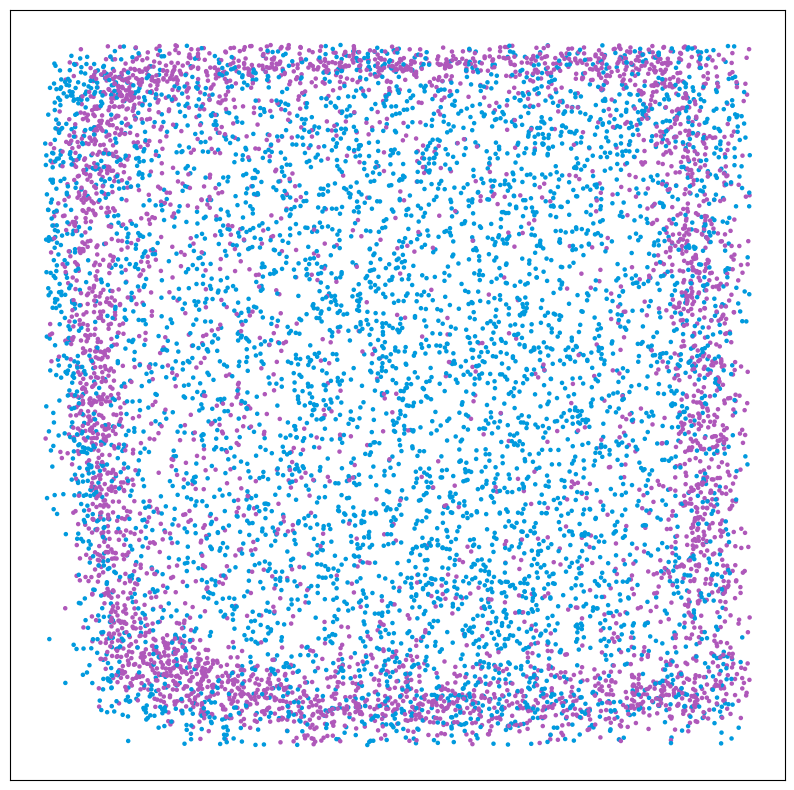

In [3]:
prov = "TO"
df = pd.read_csv('/data/housing/data/intermediate/jl_pop_synth/pop_samples/synthetic_pop_full_250709price_TO.csv')
pal= ['#009ADE', '#AF58BA'] # RM
fig, ax = sbp(figsize=(10, 10))
ax.scatter(df['x_latent'], df['y_latent'], c=df['flag_garage'].map({False: pal[0], True: pal[1]}), s=5)

ax.set_xticks([])
ax.set_yticks([])
#ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
fig.savefig(f'../paper/garage_latent.pdf', dpi=300, bbox_inches='tight')


### Figure 1 - Maps

In [67]:
geo_dict = jl_vae.load_geo_data()

turin_geo = gpd.read_file("/data/housing/data/deliverable/intermediate/All_Italy_census/Italy_census_shapefile.shp")
turin_geo.PRO_COM= turin_geo.PRO_COM.apply(lambda x: '{:06d}'.format(int(x)))
turin_geo = turin_geo.loc[turin_geo.PRO_COM=='001272',:].dissolve() # Turin city
turin_geo = turin_geo.to_crs(epsg=3857)

In [69]:
import config
from _51_abm_functions import cod_prov_abbrv_df

census = gpd.read_file(config.census_hydro_risk_path).to_crs('EPSG:3035') 
census['PRO_COM_formated'] = census['PRO_COM'].apply(lambda x: '{:06d}'.format(int(x)))
census=census.drop(columns = 'PRO_COM').rename(columns={'PRO_COM_formated':'PRO_COM'})
census = census.loc[:,['SEZ2011','PRO_COM','geometry']] 
census['SEZ2011'] =census['SEZ2011'].astype(str)


In [70]:
pal = [sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[3]]
pal= ['#009ADE', '#AF58BA'] # RM
#pal=['#009ADE','#F28523']#AF58BA
#pal = ['#AF58BA', '#F28523'] # TO
#pal = [sns.color_palette("colorblind")[7], '#F28523']


In [288]:
prov = "TO"
file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'

with open(file, 'rb') as f:
    data = pickle.load(f)

cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]
census_filter = census.assign(prov_cod = lambda x: [u[:3] for u in x["PRO_COM"]]).query("prov_cod == @cod_prov")

polyg = census_filter[["prov_cod", "geometry"]].dissolve().to_crs('EPSG:4326')


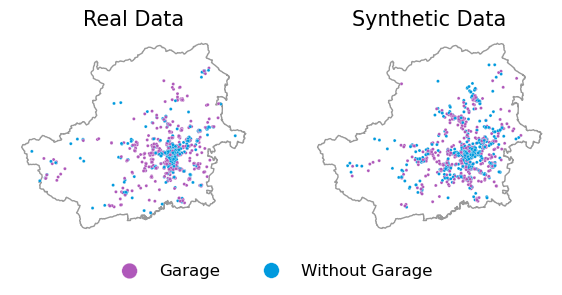

In [72]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (7,4), sharex = True, sharey = True)

fig.subplots_adjust(wspace = 0.2, hspace = 0.2)

for k,(method,title) in enumerate(zip(['df_real','df_nfvae'],
                           ['Real Data', 'Synthetic Data'])):
    
    polyg["geometry"].plot(ax = axes[k], color = "white", alpha = 0.4, edgecolor = "black")

    df_plot = data[method]
    
    sns.scatterplot(data = df_plot.sample(1000, random_state = 13).assign(flag_garage = lambda x: (x["flag_garage"] + 0.) > 0),
                    hue = "flag_garage", palette = pal,
                    x = "x", y = "y", s = 5, ax = axes[k])
    
    axes[k].set_title(title, fontsize = 15)
    axes[k].get_xaxis().set_visible(False)
    axes[k].get_yaxis().set_visible(False)
    #axes[k].legend(fontsize = 12, markerscale = 10, title_fontsize = 15,ncols = 2, frameon=False).set_title("A/C")
    axes[k].spines[["right", "top", "left", "bottom"]].set_visible(False)
    axes[k].get_legend().remove()

fig.legend(markerscale = 5, 
            labels = ["Garage", "Without Garage"], loc = 'lower center', bbox_to_anchor = (0.5, 0.1), ncol = 2,
              fontsize = 12, title_fontsize = 13, frameon=False)

#fig.savefig(f"../paper/maps_{prov}_air_conditioning_Fig1.pdf", format = "pdf",  bbox_inches='tight')

Add background

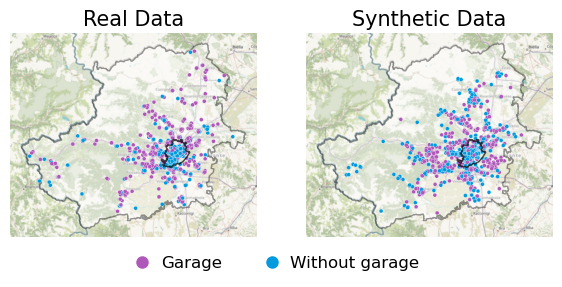

In [91]:
polyg.to_crs('EPSG:3857',inplace = True)

fig, axes = sbp(ncols = 2, nrows = 1, figsize = (7,4), sharex = True, sharey = True)

fig.subplots_adjust(wspace = 0.2, hspace = 0.2)

for k,(method,title) in enumerate(zip(['df_real','df_nfvae'],
                           ['Real Data', 'Synthetic Data'])):
    
    polyg["geometry"].plot(ax = axes[k], color = "white", alpha = 0.4, edgecolor = "black",)
    turin_geo.boundary.plot(ax = axes[k], color = "black", linewidth = 1, alpha = 0.7)

    df_plot = data[method]
    if method == "df_real":
        colors = {0: pal[0], 1: pal[1]}
    else:
        colors = {False: pal[0], True: pal[1]}
    df_plot = gpd.GeoDataFrame(df_plot, geometry = gpd.points_from_xy(df_plot.x, df_plot.y), crs = 'EPSG:4326')
    df_plot = df_plot.to_crs('EPSG:3857')

    df_plot.sort_values(by = "flag_garage", inplace = True)  # plot first the ones without A/C
    df_plot = df_plot.sample(1000, random_state = 13)
    
    
    df_plot.plot(ax = axes[k], c = df_plot["flag_garage"].map(colors), edgecolor = "white", linewidth=0.2,markersize=8) # to set the limits of the plot
    
    #sns.scatterplot(data = df_plot.sample(1000, random_state = 13).assign(flag_air_conditioning = lambda x: (x["flag_air_conditioning"] + 0.) > 0),
    #                hue = "flag_air_conditioning", palette = pal,
    #                x = "x", y = "y", s = 4, ax = axes[k],legend=False)
    cx.add_basemap(axes[k], attribution =False,crs='EPSG:3857')
    axes[k].set_title(title, fontsize = 15)
    axes[k].get_xaxis().set_visible(False)
    axes[k].get_yaxis().set_visible(False)
    #axes[k].legend(fontsize = 12, markerscale = 10, title_fontsize = 15,ncols = 2, frameon=False).set_title("A/C")
    axes[k].spines[["right", "top", "left", "bottom"]].set_visible(False)
    #axes[k].get_legend().remove()


fig.legend( handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=pal[1], markersize=10),
                          plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=pal[0], markersize=10)],
            labels = ["Garage", "Without garage"], loc = 'lower center', bbox_to_anchor = (0.5, 0.12), ncol = 2,
              fontsize = 12, title_fontsize = 13, frameon=False,handletextpad=0.1)

fig.savefig(f"../paper/maps_{prov}_garage_Fig1.pdf", format = "pdf",  bbox_inches='tight')

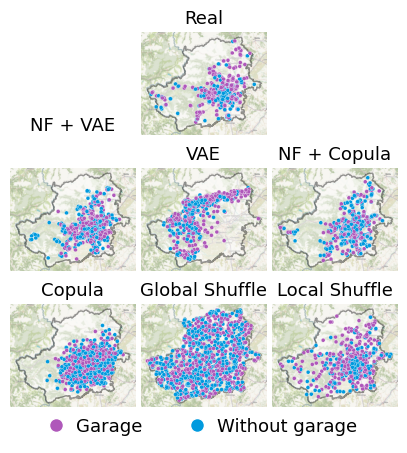

In [ ]:
polyg.to_crs('EPSG:3857',inplace = True)
# Create a mosaic where each plot is two entries wide.  Dots represent spaces.
'''
mosaic = """AABBCCDD
            .EEFFGG."""

mosaic = """AABB
            CCDD
            EEFF
            GG.."""
fig, axes = plt.subplot_mosaic(mosaic, figsize = (5,9), sharex = True, sharey = True)
'''
disposition=133
mosaic = """..AA..
            BBCCDD
            EEFFGG
            """
fig, axes = plt.subplot_mosaic(mosaic, figsize = (5,5), sharex = True, sharey = True)
fig.legend( handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=pal[1], markersize=10),
                          plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=pal[0], markersize=10)],
            labels = ["Garage", "Without garage"], loc = 'lower center', bbox_to_anchor = (0.5,0.03), ncol = 2,
              fontsize = 13, title_fontsize = 13, frameon=False,handletextpad=0.1)
'''


# 1-2-2-2

disposition=1222
mosaic = """.AA.
            BBCC
            DDEE
            FFGG"""
fig, axes = plt.subplot_mosaic(mosaic, figsize = (5,9), sharex = True, sharey = True)
fig.legend( handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=pal[1], markersize=10),
                          plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=pal[0], markersize=10)],
            labels = ["Garage", "Without garage"], loc = 'lower center', bbox_to_anchor = (0.5,0.05), ncol = 2,
              fontsize = 13, title_fontsize = 13, frameon=False,handletextpad=0.1)'''

mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G'}


fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

for k,(method,title) in enumerate(zip(['df_real','df_nfvae','df_ablation','df_shuffle_province_num','df_copula_nf','df_copula_ablation','df_shuffle_cap_num'],
                           ['Real', 'NF + VAE', 'VAE','Global Shuffle','NF + Copula','Copula','Local Shuffle'])):
    
    i= mapping[k]

    if method == '':
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        axes[i].spines[["right", "top", "left", "bottom"]].set_visible(False)
        continue

    polyg["geometry"].plot(ax = axes[i], color = "white", alpha = 0.4, edgecolor = "black")

    df_plot = data[method]
    if method in ['df_nfvae','df_ablation']:
        colors = {False: pal[0], True: pal[1]}
    else:
        colors = {0: pal[0], 1: pal[1]}

    df_plot = gpd.GeoDataFrame(df_plot, geometry = gpd.points_from_xy(df_plot.x, df_plot.y), crs = 'EPSG:4326')
    df_plot = df_plot.to_crs('EPSG:3857')

    df_plot.sort_values(by = "flag_garage", inplace = True)  # plot first the ones without A/C
    df_plot = df_plot.sample(1000, random_state = 13)
    
    
    df_plot.plot(ax = axes[i], c = df_plot["flag_garage"].map(colors), edgecolor = "white", linewidth=0.2,markersize=8) # to set the limits of the plot
    
    #sns.scatterplot(data = df_plot.sample(1000, random_state = 13).assign(flag_air_conditioning = lambda x: (x["flag_air_conditioning"] + 0.) > 0),
    #                hue = "flag_air_conditioning", palette = pal,
    #                x = "x", y = "y", s = 4, ax = axes[k],legend=False)
    cx.add_basemap(axes[i], attribution =False,crs='EPSG:3857')
    axes[i].set_title(title, fontsize = 13)
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    #axes[i].legend().set_visible(False)
    axes[i].spines[["right", "top", "left", "bottom"]].set_visible(False)
#axes[1,1].legend(fontsize = 18, markerscale = 10, title_fontsize = 18,bbox_to_anchor = (-.3, 1.)).set_title("A/C")

# 
fig.savefig(f"../paper/maps_{prov}_garage_all_methods_long_{disposition}.png", format = "png", dpi=300 , bbox_inches='tight')


# Other examples

In [224]:
prov = "ME"
prov_name = 'Messina'
file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'

with open(file, 'rb') as f:
    data = pickle.load(f)

cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]
census_filter = census.assign(prov_cod = lambda x: [u[:3] for u in x["PRO_COM"]]).query("prov_cod == @cod_prov")

polyg = census_filter[["prov_cod", "geometry"]].dissolve().to_crs('EPSG:4326')

In [225]:
data['df_real'].columns

Index(['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 'y', 'x', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4', 'log_price',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing'],
      dtype='object')

In [236]:
attrib = 'log_mq'
legend_labels =r'Home size ($m^2$)'# ['With annex', 'Without annex']

binaries = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning']
continuous = ['log_price', 'log_mq']

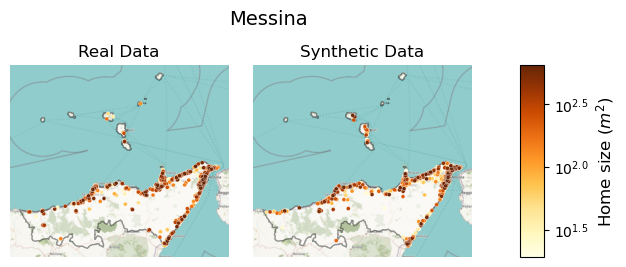

In [286]:

polyg.to_crs('EPSG:3857',inplace = True)

if attrib in continuous:
    fig, axes = sbp(ncols = 3, nrows = 1, figsize = (7,2.5), sharex = True, sharey = True, gridspec_kw={'width_ratios': [4,4, 1]})
else: 
    fig, axes = sbp(ncols = 2, nrows = 1, figsize = (7,4), sharex = True, sharey = True)

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

for k,(method,title) in enumerate(zip(['df_real','df_nfvae'],
                           ['Real Data', 'Synthetic Data'])):
    
    polyg["geometry"].plot(ax = axes[k], color = "white", alpha = 0.4, edgecolor = "black",)
    #turin_geo.boundary.plot(ax = axes[k], color = "black", linewidth = 1, alpha = 0.7)

    df_plot = data[method]


    df_plot = gpd.GeoDataFrame(df_plot, geometry = gpd.points_from_xy(df_plot.x, df_plot.y), crs = 'EPSG:4326')
    df_plot = df_plot.to_crs('EPSG:3857')

    df_plot.sort_values(by = attrib, inplace = True)  # plot first the ones without A/C
    df_plot = df_plot.sample(1000, random_state = 13)
    

    if attrib in binaries:
        if method == "df_real":
            colors = {0: pal[0], 1: pal[1]}
        else:
            colors = {False: pal[0], True: pal[1]}
        
        df_plot.plot(ax = axes[k], c = df_plot[attrib].map(colors), edgecolor = "white", linewidth=0.2,markersize=8) # to set the limits of the plot

        fig.legend( handles = [plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=pal[1], markersize=10),
                                plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=pal[0], markersize=10)],
                    labels = legend_labels, loc = 'lower center', bbox_to_anchor = (0.5, 0.15), ncol = 2,
                    fontsize = 12, title_fontsize = 13, frameon=False,handletextpad=0.1)
    elif attrib in continuous: 
        exp_attrib = np.exp(data[method][attrib])
        norm = plt.Normalize(np.log10(exp_attrib).min(), np.log10(exp_attrib).max())
        sm = plt.cm.ScalarMappable(cmap = "YlOrBr", norm=norm)
        sm.set_array([])
        if attrib == 'log_price':
            log_ticks = np.arange(1,20)
            fmt = ticker.FuncFormatter(lambda x, pos: rf"$10^{{{int(round((x)))}}}$")
            ticks = np.exp(log_ticks)  # corresponding log_price values

        elif attrib == 'log_mq':
            exp_attrib = np.exp(data[method][attrib])
            log_ticks = np.arange(0,5,0.5)
            fmt = ticker.FuncFormatter(lambda x, pos: rf"$10^{{{round(x,1)}}}$")

            ticks = np.exp(log_ticks)  # corresponding log_price values
        if k==1: 
            # add colorbar from data in the last plot
            axes[2].figure.colorbar(sm, aspect = 8, fraction = 0.5, format=fmt, 
                         ticks=log_ticks).set_label(legend_labels, fontsize = 12)
            axes[2].get_xaxis().set_visible(False)
            axes[2].get_yaxis().set_visible(False)
            axes[2].spines[["right", "top", "left", "bottom"]].set_visible(False)

        df_plot.plot(ax = axes[k], cmap ='YlOrBr',edgecolor = "white", linewidth=0.2,markersize=8) # to set the limits of the plot

        
    else:
        print(f"{attrib} not recognized")
    
    
    #sns.scatterplot(data = df_plot.sample(1000, random_state = 13).assign(flag_air_conditioning = lambda x: (x["flag_air_conditioning"] + 0.) > 0),
    #                hue = "flag_air_conditioning", palette = pal,
    #                x = "x", y = "y", s = 4, ax = axes[k],legend=False)
    cx.add_basemap(axes[k], attribution =False,crs='EPSG:3857')
    axes[k].set_title(title, fontsize = 12)
    axes[k].get_xaxis().set_visible(False)
    axes[k].get_yaxis().set_visible(False)
    #axes[k].legend(fontsize = 12, markerscale = 10, title_fontsize = 15,ncols = 2, frameon=False).set_title("A/C")
    axes[k].spines[["right", "top", "left", "bottom"]].set_visible(False)
    #axes[k].get_legend().remove()


# 
dict_y={'RM':0.83,'FI':1.1,'A0':0.82,'TO':0.83,'TN':1.05,'TS':1.1,'ME':1.1}

fig.suptitle(prov_name, fontsize = 14,y= dict_y[prov])
fig.savefig(f"../paper/maps_{prov}_{attrib}_Fig1.pdf", format = "pdf",  bbox_inches='tight')

In [285]:
exp_attrib.min(),exp_attrib.max()

(19.166585033415938, 655.5410990383144)

['High_energy_class', 'Low_energy_class', 'Medium_energy_class', 'Missing_energy_class'] not recognized
['High_energy_class', 'Low_energy_class', 'Medium_energy_class', 'Missing_energy_class'] not recognized


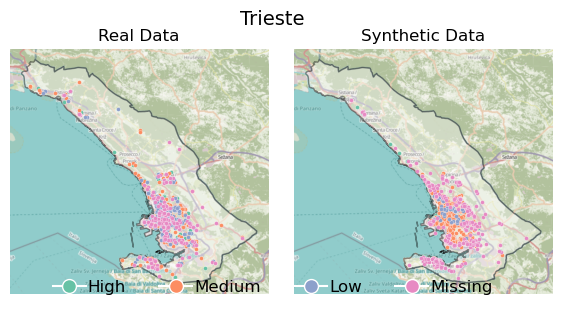

In [217]:
attrib = ['High_energy_class', 'Low_energy_class', 'Medium_energy_class','Missing_energy_class']
legend_labels =['High', 'Medium','Low','Missing']

binaries = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning']
continuous = ['log_price', 'log_mq']
categ = [['High_energy_class', 'Low_energy_class', 'Medium_energy_class','Missing_energy_class'],[]]

polyg.to_crs('EPSG:3857',inplace = True)

if attrib in continuous:
    fig, axes = sbp(ncols = 3, nrows = 1, figsize = (7,2.5), sharex = True, sharey = True, gridspec_kw={'width_ratios': [4,4, 1]})
else: 
    fig, axes = sbp(ncols = 2, nrows = 1, figsize = (7,4), sharex = True, sharey = True)

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

for k,(method,title) in enumerate(zip(['df_real','df_nfvae'],
                           ['Real Data', 'Synthetic Data'])):
    
    polyg["geometry"].plot(ax = axes[k], color = "white", alpha = 0.4, edgecolor = "black",)
    #turin_geo.boundary.plot(ax = axes[k], color = "black", linewidth = 1, alpha = 0.7)

    df_plot = data[method]


    df_plot = gpd.GeoDataFrame(df_plot, geometry = gpd.points_from_xy(df_plot.x, df_plot.y), crs = 'EPSG:4326')
    df_plot = df_plot.to_crs('EPSG:3857')

    df_plot.sort_values(by = "flag_garage", inplace = True)  # plot first the ones without A/C
    df_plot = df_plot.sample(1000, random_state = 13)
    
    legend_handles = []
    if attrib in categ:  # energy class
        categ_palette = list(sns.color_palette("Set2", n_colors=len(attrib)).as_hex())
        #categ_palette=['red', 'blue','green','grey']
        for c, label in enumerate(attrib):
            if method == "df_real":
                data_p =df_plot.loc[df_plot[label]==1, :]
            else:
                data_p =df_plot.loc[df_plot[label]==True, :]
            data_p.plot(ax = axes[k], c = categ_palette[c], edgecolor = "white", linewidth=0.2,markersize=8) # to set the limits of the plot
        
            legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=categ_palette[c], markersize=10))
        if k==1:
            fig.legend( handles = legend_handles,labels = legend_labels, loc = 'lower center', bbox_to_anchor = (0.5, 0.15), ncol = 4,
                    fontsize = 12, title_fontsize = 13, frameon=False,handletextpad=0.1)

    if attrib in binaries:
        if method == "df_real":
            colors = {0: pal[0], 1: pal[1]}
        else:
            colors = {False: pal[0], True: pal[1]}
        
        df_plot.plot(ax = axes[k], c = df_plot[attrib].map(colors), edgecolor = "white", linewidth=0.2,markersize=8) # to set the limits of the plot

        fig.legend( handles = [plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=pal[1], markersize=10),
                                plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=pal[0], markersize=10)],
                    labels = legend_labels, loc = 'lower center', bbox_to_anchor = (0.5, 0.15), ncol = 2,
                    fontsize = 12, title_fontsize = 13, frameon=False,handletextpad=0.1)
    elif attrib in continuous: 
        exp_attrib = np.exp(data[method][attrib])
        norm = plt.Normalize(np.log10(exp_attrib).min(), np.log10(exp_attrib).max())
        sm = plt.cm.ScalarMappable(cmap = "YlOrBr", norm = norm)
        sm.set_array([])

        log_ticks = np.arange(1,20)
        fmt = ticker.FuncFormatter(lambda x, pos: rf"$10^{{{int(round((x)))}}}$")
        ticks = np.exp(log_ticks)  # corresponding log_price values
        if k==1: 
            # add colorbar from data in the last plot
            axes[2].figure.colorbar(sm, aspect = 8, fraction = 0.5, format = fmt,
                         ticks = log_ticks).set_label("Price (€)", fontsize = 12)
            axes[2].get_xaxis().set_visible(False)
            axes[2].get_yaxis().set_visible(False)
            axes[2].spines[["right", "top", "left", "bottom"]].set_visible(False)

        df_plot.plot(ax = axes[k], cmap ='YlOrBr',edgecolor = "white", linewidth=0.2,markersize=8) # to set the limits of the plot

        
    else:
        print(f"{attrib} not recognized")
    

    cx.add_basemap(axes[k], attribution =False,crs='EPSG:3857')
    axes[k].set_title(title, fontsize = 12)
    axes[k].get_xaxis().set_visible(False)
    axes[k].get_yaxis().set_visible(False)
    #axes[k].legend(fontsize = 12, markerscale = 10, title_fontsize = 15,ncols = 2, frameon=False).set_title("A/C")
    axes[k].spines[["right", "top", "left", "bottom"]].set_visible(False)
    #axes[k].get_legend().remove()


# 
dict_y={'RM':0.83,'FI':1.1,'A0':0.82,'TO':0.83,'TN':0.85,'TS':0.9}

fig.suptitle(prov_name, fontsize = 14,y= dict_y[prov])
fig.savefig(f"../paper/maps_{prov}_{attrib}_Fig1.pdf", format = "pdf",  bbox_inches='tight')

In [ ]:
 sns.color_palette("Set2", n_colors=len(attrib)).as

[(0, 'High_energy_class'),
 (1, 'Low_energy_class'),
 (2, 'Medium_energy_class'),
 (3, 'Missing_energy_class')]

In [41]:
prov = "NA"
file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'

with open(file, 'rb') as f:
    data = pickle.load(f)

cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]
census_filter = census.assign(prov_cod = lambda x: [u[:3] for u in x["PRO_COM"]]).query("prov_cod == @cod_prov")

polyg = census_filter[["prov_cod", "geometry"]].dissolve().to_crs('EPSG:4326')


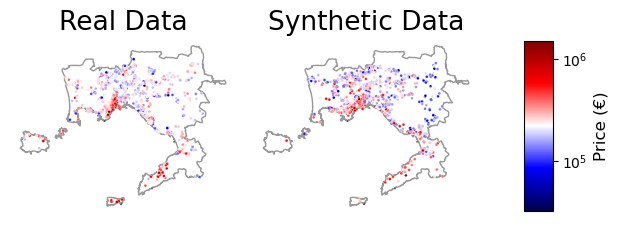

In [ ]:
fig, axes = sbp(ncols = 3, nrows = 1, figsize = (7,2.5), sharex = True, sharey = True, gridspec_kw={'width_ratios': [4,4, 1]})

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)


for k,(method,title) in enumerate(zip(['df_real','df_nfvae'],
                           ['Real Data', 'Synthetic Data'])):
    
    polyg["geometry"].plot(ax = axes[k], color = "white", alpha = 0.4, edgecolor = "black")

    df_plot = data[method]
    
    sns.scatterplot(data = df_plot.sample(1000, random_state = 13),
                    hue = "log_price",
                    palette = "seismic",
                    hue_norm = (10., 14.),
                    
                    x = "x", y = "y", s = 4, ax = axes[k])
    
    axes[k].set_title(title, fontsize = 19)
    axes[k].get_xaxis().set_visible(False)
    axes[k].get_yaxis().set_visible(False)
    axes[k].legend().set_visible(False) #.legend(fontsize = 18, markerscale = 10, title_fontsize = 18,bbox_to_anchor = (1.05, 0.95)).set_title("A/C")
    axes[k].spines[["right", "top", "left", "bottom"]].set_visible(False)

prices = np.exp(data["df_real"]["log_price"])
norm = plt.Normalize(np.log10(prices).min(), np.log10(prices).max())
sm = plt.cm.ScalarMappable(cmap = "seismic", norm = norm)
sm.set_array([])

log_ticks = np.arange(1,20)
ticks = np.exp(log_ticks)  # corresponding log_price values

fmt = ticker.FuncFormatter(lambda x, pos: rf"$10^{{{int(round((x)))}}}$")
#fmt = ticker.FuncFormatter(lambda x, pos: rf"$10^{{{int(round(np.log10(x)))}}}$")



axes[2].figure.colorbar(sm, aspect = 6, fraction = 0.5, format = fmt,
                         ticks = log_ticks).set_label("Price (€)", fontsize = 12)
axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
    
axes[2].spines[["right", "top", "left", "bottom"]].set_visible(False)


fig.savefig("../paper/maps_NA_log_price.png", format = "png",  bbox_inches='tight')


In [20]:
prov = "TO"
file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'

with open(file, 'rb') as f:
    data = pickle.load(f)

cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]
census_filter = census.assign(prov_cod = lambda x: [u[:3] for u in x["PRO_COM"]]).query("prov_cod == @cod_prov")

polyg = census_filter[["prov_cod", "geometry"]].dissolve().to_crs('EPSG:4326')


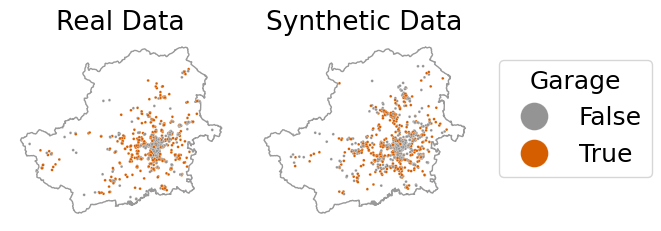

In [21]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (6,2.5), sharex = True, sharey = True)

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

for k,(method,title) in enumerate(zip(['df_real','df_nfvae'],
                           ['Real Data', 'Synthetic Data'])):
    
    polyg["geometry"].plot(ax = axes[k], color = "white", alpha = 0.4, edgecolor = "black")

    df_plot = data[method]
    
    sns.scatterplot(data = df_plot.sample(1000, random_state = 13).assign(flag_garage = lambda x: (x["flag_garage"] + 0.) > 0),
                    hue = "flag_garage", palette = pal,
                    x = "x", y = "y", s = 4, ax = axes[k])
    
    axes[k].set_title(title, fontsize = 19)
    axes[k].get_xaxis().set_visible(False)
    axes[k].get_yaxis().set_visible(False)
    axes[k].legend(fontsize = 18, markerscale = 10, title_fontsize = 18,bbox_to_anchor = (1.05, 0.95)).set_title("Garage")
    axes[k].spines[["right", "top", "left", "bottom"]].set_visible(False)

axes[0].get_legend().remove()


fig.savefig(f"../paper/maps_{prov}_garage.png", format = "png",  bbox_inches='tight')


In [22]:
prov = "RM"
file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'

with open(file, 'rb') as f:
    data = pickle.load(f)

cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]
census_filter = census.assign(prov_cod = lambda x: [u[:3] for u in x["PRO_COM"]]).query("prov_cod == @cod_prov")

polyg = census_filter[["prov_cod", "geometry"]].dissolve().to_crs('EPSG:4326')


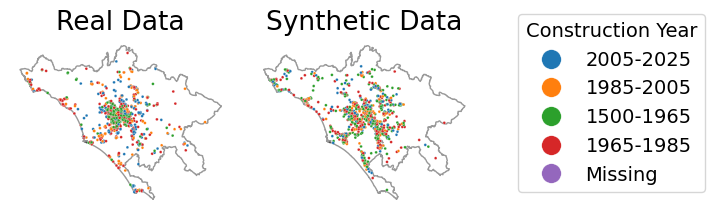

In [37]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (6,2.5), sharex = True, sharey = True)

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

for k,(method,title) in enumerate(zip(['df_real','df_nfvae'],
                           ['Real Data', 'Synthetic Data'])):
    
    polyg["geometry"].plot(ax = axes[k], color = "white", alpha = 0.4, edgecolor = "black")

    df_plot = data[method]
    df_plot["Construction Year"] = pd.from_dummies(data["df_real"][[u for u in data["df_real"].columns if "ANNO" in u]].rename(columns = {u: u.replace("ANNO_COSTRUZIONE_", "").replace("_", "-") for u in data["df_real"].columns}))

    
    sns.scatterplot(data = df_plot.sample(1000, random_state = 13),
                    hue = "Construction Year", #palette = pal,
                    x = "x", y = "y", s = 4, ax = axes[k])
    
    axes[k].set_title(title, fontsize = 19)
    axes[k].get_xaxis().set_visible(False)
    axes[k].get_yaxis().set_visible(False)
    axes[k].legend(fontsize = 14, markerscale = 7, title_fontsize = 14,bbox_to_anchor = (1.15, 1.2)).set_title("Construction Year")
    axes[k].spines[["right", "top", "left", "bottom"]].set_visible(False)

axes[0].get_legend().remove()


fig.savefig(f"../paper/maps_{prov}_construction.png", format = "png",  bbox_inches='tight')


In [46]:
prov = "AO"
file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'

with open(file, 'rb') as f:
    data = pickle.load(f)

cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]
census_filter = census.assign(prov_cod = lambda x: [u[:3] for u in x["PRO_COM"]]).query("prov_cod == @cod_prov")

polyg = census_filter[["prov_cod", "geometry"]].dissolve().to_crs('EPSG:4326')


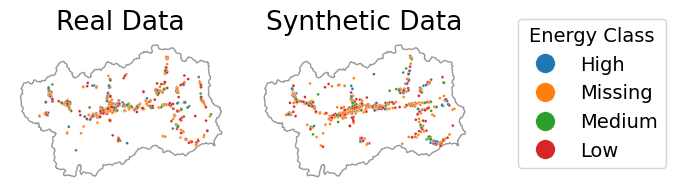

In [47]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (6,2.5), sharex = True, sharey = True)

fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

for k,(method,title) in enumerate(zip(['df_real','df_nfvae'],
                           ['Real Data', 'Synthetic Data'])):
    
    polyg["geometry"].plot(ax = axes[k], color = "white", alpha = 0.4, edgecolor = "black")

    df_plot = data[method]
    df_plot["Energy Class"] = pd.from_dummies(data["df_real"][[u for u in data["df_real"].columns if "energy" in u]].rename(columns = {u: u.replace("_energy_class", "") for u in data["df_real"].columns}))

    
    sns.scatterplot(data = df_plot.sample(1000, random_state = 13),
                    hue = "Energy Class", #palette = pal,
                    x = "x", y = "y", s = 4, ax = axes[k])
    
    axes[k].set_title(title, fontsize = 19)
    axes[k].get_xaxis().set_visible(False)
    axes[k].get_yaxis().set_visible(False)
    axes[k].legend(fontsize = 14, markerscale = 7, title_fontsize = 14,bbox_to_anchor = (1.15, 1.2)).set_title("Energy Class")
    axes[k].spines[["right", "top", "left", "bottom"]].set_visible(False)

axes[0].get_legend().remove()


fig.savefig(f"../paper/maps_{prov}_energy.png", format = "png",  bbox_inches='tight')


### Figure 3 - Boxplots

In [1]:
n_houses = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/n_houses_prov_isp.csv", index_col = 0)

NameError: name 'pd' is not defined

In [6]:
df_wsd = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_wasserstein_geo_isp.csv", index_col = 0)
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_isp.csv", index_col = 0).T
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_pca_isp.csv", index_col = 0).T
#weighting= "exp"
#weighting= "dist_threshold"
weighting= "nearest_k"
df_moran = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_moran_{weighting}_isp.csv", index_col = 0)
df_moran = df_moran.apply(lambda x: np.abs(x - x["df_real"]), axis = 1)
df_corr = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_correlation_features_isp.csv", index_col = 0).T

df_zerocell = pd.read_csv(f'/data/housing/data/intermediate/jl_pop_synth/zero_cell_ips.csv', index_col = 0)

df_r2 = pd.read_csv(f'/data/housing/data/intermediate/jl_pop_synth/utility_r2_regression_vs_real_price_isp.csv', index_col = 0)
df_r2 = (df_r2["df_real"] - df_r2.T).T


# euclidean norm1
metric = "euclidean"
mia_auc_roc = pd.read_csv(f'/data/housing/data/intermediate/lc_privacyStats/MIA_auc_roc_{metric}.csv')
df_privacy = (mia_auc_roc.dropna()
              .query("classifier == 'Logistic Regression'")
              .set_index(["pop_name", "prov"]).drop(columns = ["classifier"]).unstack()
              .apply(lambda x: np.abs(x - 0.5))
              .T.rename(columns = {u: u.replace("95", "") for u in mia_auc_roc["pop_name"].unique()})
              .loc["score"]
              )

df_privacy.index.name = None
df_privacy.columns.name = None

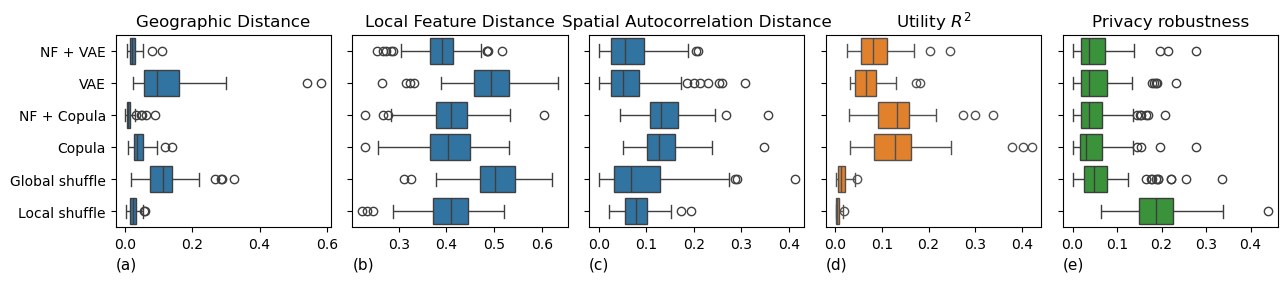

In [ ]:
fig, axes = sbp(figsize = (15,2.5), ncols = 5, sharey = True)

fig.subplots_adjust(wspace = 0.1)
for k, (df_, title) in enumerate(zip([df_wsd, df_geo_features, df_moran,df_r2, df_privacy.assign(df_real = 0)], ["Geographic Distance", "Local Feature Distance", "Spatial Autocorrelation Distance", r"Utility $R^2$", "Privacy robustness"])):
    sns.boxplot(data = (df_
                        .drop(columns = ["df_real", "df_shuffle_cap_bins", "df_shuffle_province_bins"])
                        .rename(columns = {"df_nfvae": "NF + VAE", 
                                           "df_ablation": "VAE",
                                           "df_copula_nf": "NF + Copula",
                                           "df_copula_ablation": "Copula",
                                           "df_shuffle_province_num": "Global shuffle",
                                           "df_shuffle_cap_num": "Local shuffle"})
                        .stack().reset_index().rename(columns = {"level_0": "prov","level_1": "method", 0: "metric"})),
                x = "metric",
                y = "method",
                color = [sns.color_palette()[u] for u in [0,0,0,1,2]][k],
                ax = axes[k]
                )
    axes[k].set_title(title)
    axes[k].set_xlabel("")
    axes[k].set_ylabel("")
    xt, _ = axes[k].get_xlim()
    axes[k].text(xt,6.8, f'({["a", "b", "c", "d", "e"][k]})', fontsize = 11)

#fig.savefig("../paper/boxplots_distances.pdf", format = "pdf", bbox_inches = "tight")

### Correlation distance

In [4]:
df_corr = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_correlation_features_isp.csv", index_col = 0).T


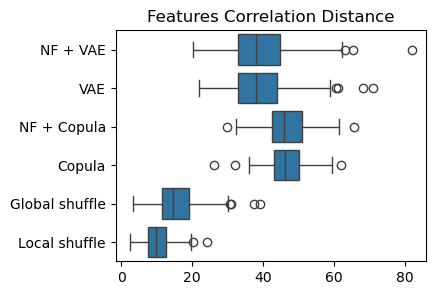

In [56]:
fig, axes = sbp(figsize = (4,3))

sns.boxplot(data = (df_corr
                        .drop(columns = ["df_real", "df_shuffle_cap_bins", "df_shuffle_province_bins"])
                        .rename(columns = {"df_nfvae": "NF + VAE", 
                                           "df_ablation": "VAE",
                                           "df_copula_nf": "NF + Copula",
                                           "df_copula_ablation": "Copula",
                                           "df_shuffle_province_num": "Global shuffle",
                                           "df_shuffle_cap_num": "Local shuffle"})
                        .stack().reset_index().rename(columns = {"level_0": "prov","level_1": "method", 0: "metric"})
                        ),
                x = "metric",
                y = "method",
                )

axes.set_title("Features Correlation Distance")
axes.set_xlabel("")
axes.set_ylabel("")

fig.savefig("../paper/boxplot_correlations_sm.pdf", format = "pdf", bbox_inches='tight')

In [5]:
prov = "BA"
file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'

with open(file, 'rb') as f:
    data = pickle.load(f)

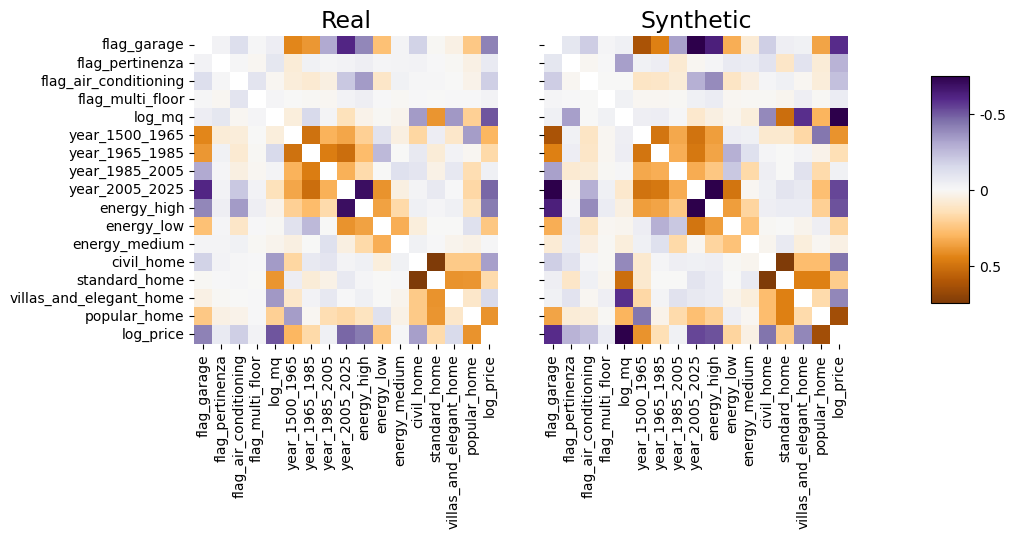

In [11]:
v = 0.6
fig, axes = sbp(ncols = 3, figsize = (10,4), gridspec_kw={'width_ratios': [4,4, 1]}, sharey = True)
#fig.subplots_adjust(wspace = 1, )
for j,(df_, title) in enumerate(zip([data["df_real"], data["df_nfvae"]], ["Real", "Synthetic"])):
    sns.heatmap(df_
                .drop(columns = ["x", "y", "Missing_energy_class", "floor_Missing", "flag_air_conditioning_Missing", "flag_multi_floor_Missing","ANNO_COSTRUZIONE_Missing",
                                    'floor_0.0', 'floor_1.0', 'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4'])
                .rename(columns = {u: u.replace("ANNO_COSTRUZIONE_", "year_").replace("High_energy_class", "energy_high")
                                   .replace("Medium_energy_class", "energy_medium").replace("Low_energy_class", "energy_low")
                                    .replace("COD_CAT_A02", "civil_home").replace("COD_CAT_A03", "standard_home").replace("COD_CAT_A_04_05", "popular_home").replace("COD_CAT_A_01_07_08", "villas_and_elegant_home") for u in df_.columns})
                .corr().replace(1, np.nan),
                                    vmin = -v, vmax = v,
                                    cmap = "PuOr",
                                    cbar = False,
                                    ax = axes[j])
    axes[j].set_title(title, fontsize = 17)
axes[2].set_visible(False)
sm = plt.cm.ScalarMappable(cmap = "PuOr")
sm.set_array([])

#log_ticks = np.arange(1,20)
#ticks = np.exp(log_ticks)  # corresponding log_price values

#fmt = ticker.FuncFormatter(lambda x, pos: rf"$10^{{{int(round((x)))}}}$")
#fmt = ticker.FuncFormatter(lambda x, pos: rf"$10^{{{int(round(np.log10(x)))}}}$")

l = 0.5
l_trans = l / v
axes[2].figure.colorbar(sm, aspect = 6, fraction = 0.5, #format = fmt,
                         ticks = [l_trans, 0.5, 1 - l_trans],
                         ).set_ticklabels([-l, 0, l])

fig.savefig("../paper/heatmap_correlations_BO_sm.pdf", format = "pdf", bbox_inches='tight')


### Zero cell

In [29]:
df_zerocell = pd.read_csv(f'/data/housing/data/intermediate/jl_pop_synth/zero_cell_ips.csv', index_col = 0).T

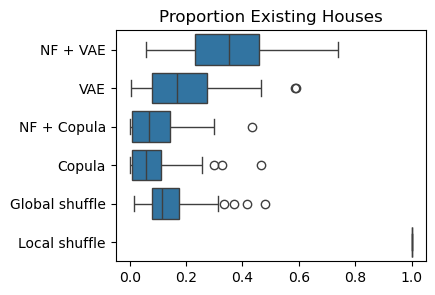

In [31]:
fig, axes = sbp(figsize = (4,3))

sns.boxplot(data = (df_zerocell
                        .drop(columns = ["df_real", "df_shuffle_cap_bins", "df_shuffle_province_bins"])
                        .rename(columns = {"df_nfvae": "NF + VAE", 
                                           "df_ablation": "VAE",
                                           "df_copula_nf": "NF + Copula",
                                           "df_copula_ablation": "Copula",
                                           "df_shuffle_province_num": "Global shuffle",
                                           "df_shuffle_cap_num": "Local shuffle"})
                        .stack().reset_index().rename(columns = {"level_0": "prov","level_1": "method", 0: "metric"})
                        ),
                x = "metric",
                y = "method",
                )

axes.set_title("Proportion Existing Houses")
axes.set_xlabel("")
axes.set_ylabel("")

fig.savefig("../paper/boxplot_zerocell_sm.pdf", format = "pdf", bbox_inches='tight')

### Robustness Moran

In [31]:
weighting= "dist_threshold"
df_moran = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_moran_{weighting}_isp.csv", index_col = 0)
df_moran = df_moran.apply(lambda x: np.abs(x - x["df_real"]), axis = 1)


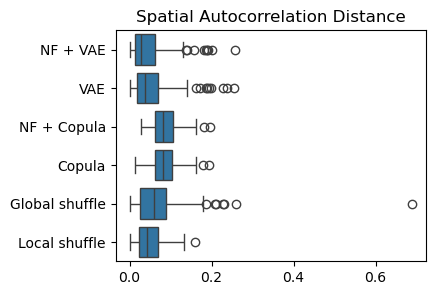

In [34]:
fig, axes = sbp(figsize = (4,3))

sns.boxplot(data = (df_moran
                        .drop(columns = ["df_real", "df_shuffle_cap_bins", "df_shuffle_province_bins"])
                        .rename(columns = {"df_nfvae": "NF + VAE", 
                                           "df_ablation": "VAE",
                                           "df_copula_nf": "NF + Copula",
                                           "df_copula_ablation": "Copula",
                                           "df_shuffle_province_num": "Global shuffle",
                                           "df_shuffle_cap_num": "Local shuffle"})
                        .stack().reset_index().rename(columns = {"level_0": "prov","level_1": "method", 0: "metric"})
                        ),
                x = "metric",
                y = "method",
                )

axes.set_title("Spatial Autocorrelation Distance")
axes.set_xlabel("")
axes.set_ylabel("")

fig.savefig("../paper/boxplot_moran_sm.pdf", format = "pdf", bbox_inches='tight')

### AirBnB boxplots

In [16]:
df_wsd = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_wasserstein_geo_airbnb.csv", index_col = 0)
df_corr = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_correlation_features_airbnb.csv", index_col = 0)
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_airbnb.csv", index_col = 0)

df_zerocell = pd.read_csv(f'/data/housing/data/intermediate/jl_pop_synth/zero_cell_airbnb.csv', index_col = 0)

df_r2 = pd.read_csv(f'/data/housing/data/intermediate/jl_pop_synth/utility_r2_regression_vs_real_price_airbnb.csv', index_col = 0)

<Axes: xlabel='metric', ylabel='method'>

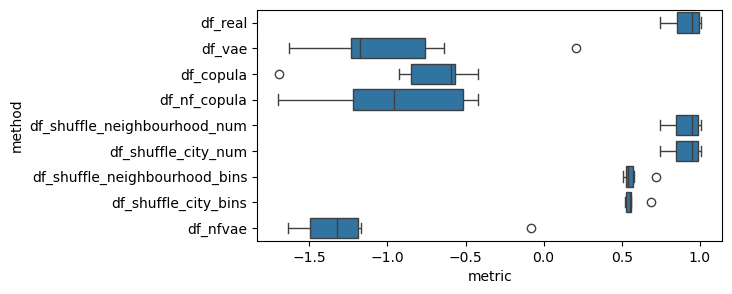

In [31]:
fig, axes = sbp(figsize = (6,3))


sns.boxplot(data = df_r2.apply(lambda x: (x - x.mean()) / x.std(), axis = 1).stack().reset_index().rename(columns = {"level_0": "prov","level_1": "method", 0: "metric"}),
            x = "metric",
            y = "method"
             )

### Fig SM - Privacy

In [376]:
remove_pops = ['df_real', 'df_shuffle_cap_bins', 'df_shuffle_province_bins']
df_privacy_all = (mia_auc_roc
                  .replace({u: u.replace("95", "") for u in mia_auc_roc["pop_name"].unique()})
                  .replace({"df_nfvae": "NF + VAE", 
                                           "df_ablation": "VAE",
                                           "df_copula_nf": "NF + Copula",
                                           "df_copula_ablation": "Copula",
                                           "df_shuffle_province_num": "Global shuffle",
                                           "df_shuffle_cap_num": "Local shuffle"})
                  .query("pop_name not in @remove_pops")
                  .assign(score = lambda x: np.abs(x["score"] - 0.5)))

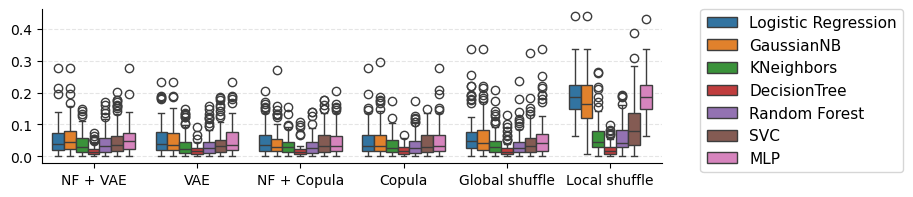

In [402]:
fig, axes = sbp(figsize = (8, 2))

sns.boxplot(data = df_privacy_all, x = "pop_name", y = "score", hue = "classifier")
axes.set_xlabel("")
axes.set_ylabel("")
#axes.legend(fontsize = 18, markerscale = 10, title_fontsize = 18,bbox_to_anchor = (1.05, 0.95)).set_title("")
axes.legend(fontsize = 11, bbox_to_anchor = (1.05, 1.05)).set_title("")

axes.yaxis.grid(color = "gray", alpha = 0.2, linestyle = "dashed")
axes.spines[["right", "top"]].set_visible(False)

fig.savefig("../paper/boxplots_privacy_all_classifiers.pdf", format = "pdf", bbox_inches='tight')

In [ ]:
(mia_auc_roc.dropna()
              #.query("classifier == 'Logistic Regression'")
                .set_index(["pop_name", "prov"]).drop(columns = ["classifier"]).unstack()
              .apply(lambda x: np.abs(x - 0.5))
              .T.rename(columns = {u: u.replace("95", "") for u in mia_auc_roc["pop_name"].unique()})
              .loc["score"]
              .drop(columns = ["df_real", "df_shuffle_cap_bins", "df_shuffle_province_bins"])
                .rename(columns = {"df_nfvae": "NF + VAE", 
                                           "df_ablation": "VAE",
                                           "df_copula_nf": "NF + Copula",
                                           "df_copula_ablation": "Copula",
                                           "df_shuffle_province_num": "Global shuffle",
                                           "df_shuffle_cap_num": "Local shuffle"})
                        
              )

ValueError: Index contains duplicate entries, cannot reshape

### Fig SM - Hyperparameter

In [ ]:
from glob import glob
from dcor import energy_distance
import torch
from tqdm import tqdm

In [71]:
def get_cap_from_xy(df, geo_dict):
    df_geo = gpd.points_from_xy(df['x'], df['y'], z=None, crs="EPSG:4326")
    df_geo = df_geo.to_crs('EPSG:3035') #4326 3035
    if "CAP" in df.columns:
        df_ = df.drop(columns = ["CAP"]).copy()
    else:
        df_ = df.copy()
    df_gpd = gpd.GeoDataFrame(df_, geometry= df_geo)
    
    df_join = (gpd.tools.sjoin(df_gpd, geo_dict["cap"], 
                             predicate="within", how='left'))
    CAP = df_join["CAP"]
    
    return CAP.groupby(CAP.index).first()


In [98]:
def proportion_obs_houses(data, geo_dict):
    df_real = data["df_real"].copy()
    bins_mq = pd.qcut(df_real["log_mq"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_price = pd.qcut(df_real["log_price"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_mq[0] = -np.inf
    bins_mq[-1] = np.inf
    bins_price[0] = -np.inf
    bins_price[-1] = np.inf
        

    data_bins = {}
    for k in list(data):
        df_ = data[k][df_real.columns].copy() + 0.
        df_["bin_mq"] = pd.cut(df_["log_mq"], bins = bins_mq)
        df_["bin_price"] = pd.cut(df_["log_price"], bins = bins_price)
        cap = get_cap_from_xy(df_, geo_dict)

        df_["CAP"] = cap
        df_.drop(columns = ["x", "y", "log_price", "log_mq"], inplace = True)
        data_bins[k] = df_
    
    drop_cols = []
    #df_real_list = [list(u) for _,u in data_bins["df_real"].drop(columns = drop_cols).iterrows()]
    #in_real = {k: np.mean([list(data_bins[k].drop(columns = drop_cols).iloc[u,:]) in df_real_list for u in range(len(data_bins[k]))]) for k in data_bins}

    #in_real = {k: data_bins[k].merge(data_bins["df_real"], how = "outer", indicator = True)
    #           .query("_merge != 'right_only'")["_merge"]
    #           .value_counts(normalize = True).loc["both"]
    #           for k in data_bins}
    in_real = {k:data_bins[k].set_index(list(data_bins["df_real"])).index.isin(data_bins["df_real"].set_index(list(data_bins["df_real"])).index).mean() for k in data_bins}
    
    return in_real


In [4]:
prov = "TO"
file_real = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
with open(file_real, 'rb') as f:
    df_real = pickle.load(f)["df_real"]
    

In [5]:
df_real.columns

Index(['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 'y', 'x', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4', 'log_price',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing'],
      dtype='object')

In [35]:
provinces = list(set([f.split(".")[-2].split("_")[-1] for f in sorted(glob(jl_vae.path_pop_synth + f"pop_samples/hyper_*_*.csv"))]))

In [79]:
hyper_samples = {}


for prov in provinces:
    file_real = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
    with open(file_real, 'rb') as f:
        df_real = pickle.load(f)["df_real"]
        
    for file in sorted(glob(jl_vae.path_pop_synth + f"pop_samples/hyper_*_{prov}.csv")):
        
        
        lambda_kl = float(file.split("kl")[1].split("_")[0])
        lambda_geo = float(file.split("geo")[1].split("_")[0])

        hyper_samples[(prov,lambda_geo, lambda_kl)] = pd.read_csv(file, index_col = 0).sample(len(df_real), random_state = 12344, replace = True).reset_index(drop = True)

In [123]:
coord_distance = {k:energy_distance(hyper_samples[k][["x", "y"]], torch.tensor(np.array(df_real[["x", "y"]]))) for k in hyper_samples}

In [125]:
corr_distance = {k:((hyper_samples[k].drop(columns = ["x", "y"]).corr().fillna(0) - df_real.drop(columns = ["x", "y"]).corr().fillna(0)) ** 2).sum().sum() for k in hyper_samples}

In [194]:
prov = "MT"
file_real = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
if True:
    with open(file_real, 'rb') as f:
        df_real = pickle.load(f)["df_real"]
    

In [195]:
len(df_real)

1182

In [115]:
obs_houses = {}
for prov in tqdm(provinces):
    
    file_real = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
    with open(file_real, 'rb') as f:
        df_real = pickle.load(f)["df_real"]
    
    data = {k: hyper_samples[k] for k in hyper_samples if k[0] == prov}
    data["df_real"] = df_real


    obs_houses_prov = proportion_obs_houses(data, geo_dict)
    obs_houses_prov.pop("df_real")
    
    obs_houses.update(obs_houses_prov)
    


100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


In [31]:
#pd.DataFrame(coord_distance.values(), index = coord_distance.keys()).reset_index().rename(columns = {"level_0": "prov", "level_1": "geo_lambda", "level_2": "kl_lambda", 0: "distance"}).to_csv("/data/housing/data/intermediate/jl_pop_synth/hyper_lambda_coord_distance.csv")
#pd.DataFrame(corr_distance.values(), index = corr_distance.keys()).reset_index().rename(columns = {"level_0": "prov", "level_1": "geo_lambda", "level_2": "kl_lambda", 0: "distance"}).to_csv("/data/housing/data/intermediate/jl_pop_synth/hyper_lambda_corr_distance.csv")
#pd.DataFrame(obs_houses.values(), index = obs_houses.keys()).reset_index().rename(columns = {"level_0": "prov", "level_1": "geo_lambda", "level_2": "kl_lambda", 0: "distance"}).to_csv("/data/housing/data/intermediate/jl_pop_synth/hyper_lambda_obs_houses.csv")

coord_distance_df = pd.read_csv("/data/housing/data/intermediate/jl_pop_synth/hyper_lambda_coord_distance.csv", index_col = 0)
corr_distance_df = pd.read_csv("/data/housing/data/intermediate/jl_pop_synth/hyper_lambda_corr_distance.csv", index_col = 0)
obs_houses_df = pd.read_csv("/data/housing/data/intermediate/jl_pop_synth/hyper_lambda_obs_houses.csv", index_col = 0)

In [32]:
good_provinces = ["RM", "BO", "VV"]

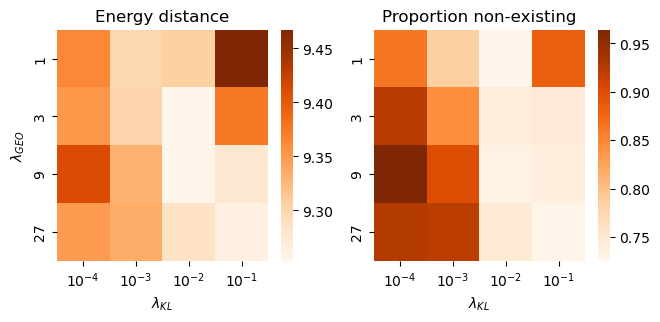

In [44]:
fig, axes = sbp(ncols = 2, figsize = (7.5,3))

for j, df_ in enumerate([coord_distance_df, obs_houses_df.assign(distance = lambda x: 1-x["distance"])]):
    sns.heatmap(data = (df_
                        .assign(geo_lambda = lambda x: (x["geo_lambda"] / 10).astype(int),
                                kl_lambda = lambda x: x["kl_lambda"] / 10)
                                
                        .query("prov in @good_provinces").groupby(["geo_lambda", "kl_lambda"])
                        .mean(numeric_only = True).unstack()["distance"]),
                ax = axes[j],
                cmap = "Oranges"
                )
    xticks = df_["kl_lambda"].unique() / 10
    axes[j].set_xlabel(r"$\lambda_{KL}$")
    axes[j].set_ylabel([r"$\lambda_{GEO}$", "", ""][j])
    axes[j].set_title(["Energy distance", "Proportion non-existing"][j])
    axes[j].set_xticklabels([r"$10^{%d}$" % int(np.log10(x)) for x in xticks])



fig.savefig("../paper/tuning_lambda_RM_BO_VV.pdf", format = "pdf", bbox_inches='tight')


In [178]:
prov = "RM"
file_real = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
with open(file_real, 'rb') as f:
    df_real = pickle.load(f)["df_real"]
    

<Axes: xlabel='x', ylabel='y'>

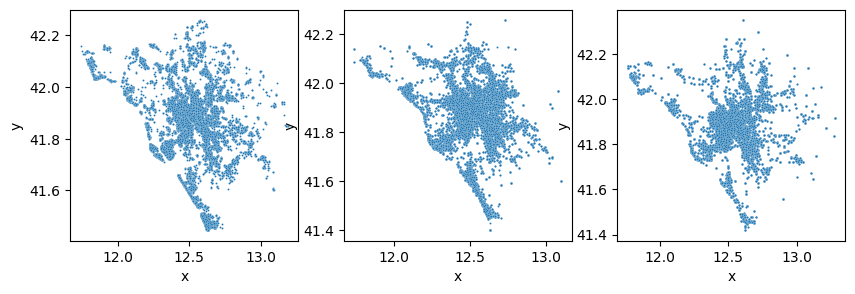

In [179]:
fig, axes = sbp(ncols = 3, figsize = (10, 3))

sns.scatterplot(data = df_real, x = "x", y = "y", ax = axes[0], s = 2)
sns.scatterplot(data = hyper_samples[(prov, 30, .1)], x = "x", y = "y", ax = axes[1], s = 2)
sns.scatterplot(data = hyper_samples[(prov, 30, 0.001)], x = "x", y = "y", ax = axes[2], s = 2)

# Tables 

In [ ]:
pd.read_csv('/data/housing/data/intermediate/regression_syn_homes/airbnb_utility.csv')